# Predicting Subscription to a Video Game Newsletter Based on Age and Time Played on the Game

### By: Lila, Lauren, and Khush

## Introduction

Researchers have been collecting data on how gamers play video games. They have done this by collecting data through a server created by the data scientists on the game 'Minecraft'. This data can be used to explore a number of different questions.

The question we aim to answer through this report is *'Can age and time played of a player predict subscription to a newsletter in players.csv?'*

The dataset titled "players.csv" will be used to answer this question. It contains Information about each player observed. The information included is described in the table below. 

| Column Name           | Data Type        | Description                                                       |
|-----------------------|------------------|-------------------------------------------------------------------|
| experience | Categorical (string) | The players experience (Beginner, Amateur, Veteran, Pro) |
| subscribe | Boolean | Whether or not the player has suscribed to a game-related newsletter (true or false) |
| hashedEmail | String | The hashed email of the player |
| played_hours | Numerical | The hours they have spent playing |
| name | String | The name of the player |
| gender | Categorical | The gender of the player |
| Age | Numerical | The age of the player |

This dataset has 7 columns and 196 rows. 

For this report we will be focusing on just the age of the player, the time that they have spent playing, and whether or not they have suscribed to a game-related newsletter.

## Methods & Results

In this analysis, we investigated whether a player's age and the number of hours they play the game can predict their subscription to a game-related newsletter using K-Nearest Neighbours (KNN) classification.

First, we cleaned the dataset by dropping irrelevant columns: "name", "hashedEmail", "gender" and experience" as they are not conceptually related to the question being investigated. We also dropped rows with "NA" to make the dataset ready for K-NN classification because a dataset with rows that contain "NA" would cause errors in the classification.

We then standardized the subscription labels to use "Yes/No" instead of "TRUE/FALSE" as it is more more easily understood and reduces ambiguity. We also scaled both predictor variables to make sure the distance metric for K-NN uses them with equal weighting.

We then made explanatory summaries and visualizations to understand data patterns before the modeling and classification. This helped us gain a rough idea of what the expected outcome could be.

Next, we split the data into training and testing data into 75% and 25% respectively. Using the training dataset, we determined the most effective K value. We did this by using a range of K values and gathering information on their accuracies and generating a plot to visualize this information. We chose the optimal K value for this classification problem based on highest accuracy and then performed the classification in the testing set using this K value to generate predictions for the dataset.

Finally, we analysed performance by generating a confusion matrix from which we evaluated accuracy and classification. These results were then used to answer the original question: *Can age and time played of a player predict subscription to a newsletter in players.csv?*

In [1]:
library(tidyverse)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
#loading and viewing the dataset to take a look at the variables. 
players_original <- read_csv("players.csv")
head(players_original)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [3]:
#Dropping Columns with NA
#Setting subscribe as factor and renaming true/false to yes/no
#Scaling predictor variables 
#Selecting relevant columns only

players <- players_original |>
drop_na(played_hours, Age, subscribe) |>
mutate(subscribe = as.factor(subscribe),
       subscribe = fct_recode(subscribe, "Yes" = "TRUE", "No" = "FALSE"),
       Age = scale(Age),
       played_hours = scale(played_hours)) |>
select(played_hours, Age, subscribe)

#view changes
head(players)

played_hours,Age,subscribe
"<dbl[,1]>","<dbl[,1]>",<fct>
0.85603962,-1.64271848,Yes
-0.07385234,-0.56012864,Yes
-0.20719534,-0.56012864,No
-0.18263216,-0.01883372,Yes
-0.20368631,-0.01883372,Yes
-0.20719534,-0.56012864,Yes


In [4]:
# Totalling the number of players based on subscription

subscriber_counts <- players |>
    group_by(subscribe) |>
    summarize(count=n())

#view results
subscriber_counts

subscribe,count
<fct>,<int>
No,52
Yes,142


In [5]:
# Minimum, maximum and mean number of player's age and number of hours played
# Age
age_summary <- players |>
    summarize(age_min = min(Age, na.rm=TRUE),
             age_max = max(Age, na.rm=TRUE),
             age_mean = mean(Age, na.rm=TRUE))

age_summary

# Hours played
played_hours_summary <- players |>
    summarize(played_hours_min = min(played_hours, na.rm=TRUE),
             played_hours_max = max(played_hours, na.rm=TRUE),
             played_hours_mean = mean(played_hours, na.rm=TRUE))

played_hours_summary

age_min,age_max,age_mean
<dbl>,<dbl>,<dbl>
-1.642718,4.988144,-1.749405e-16


played_hours_min,played_hours_max,played_hours_mean
<dbl>,<dbl>,<dbl>
-0.2071953,7.621442,1.644872e-17


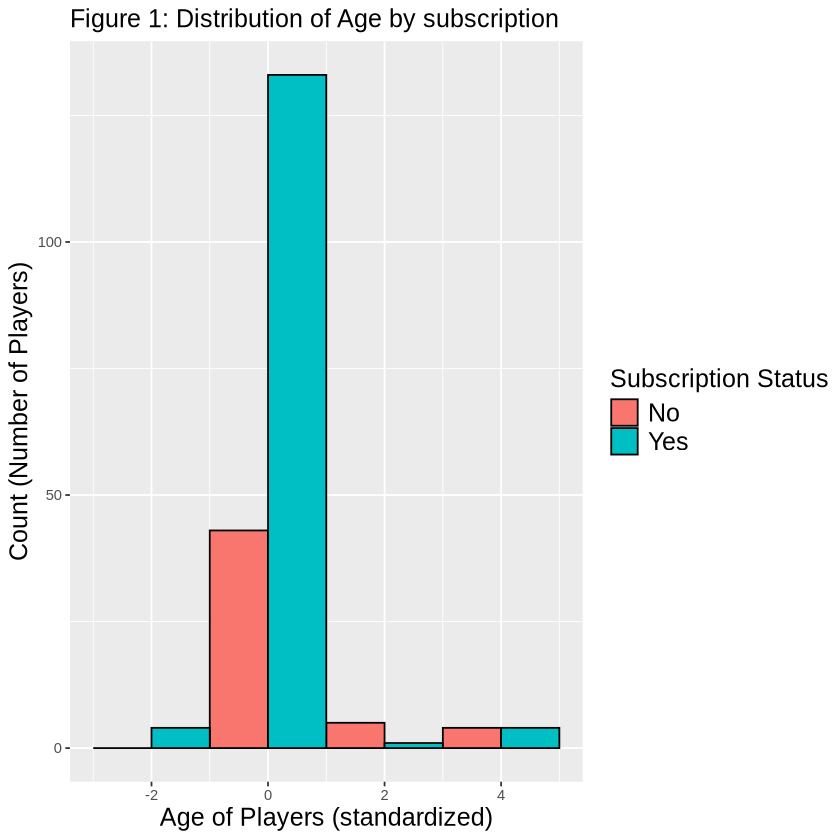

In [6]:
#Distribution of Age by subscription Histogram. 
#This helps visualize the age of subscribed vs not subscribed players. 

age_plot <- ggplot(players, aes(x = Age, fill = subscribe)) +
geom_histogram(binwidth = 2, color = "black", position = "dodge") +
labs(x = "Age of Players (standardized)", 
     y = "Count (Number of Players)", 
     title = "Figure 1: Distribution of Age by subscription", 
    fill = "Subscription Status") +
theme(plot.title = element_text(size = 15),
      axis.title = element_text(size = 15),
      legend.title = element_text(size = 15),
      legend.text = element_text(size = 15))

#view the plot
age_plot

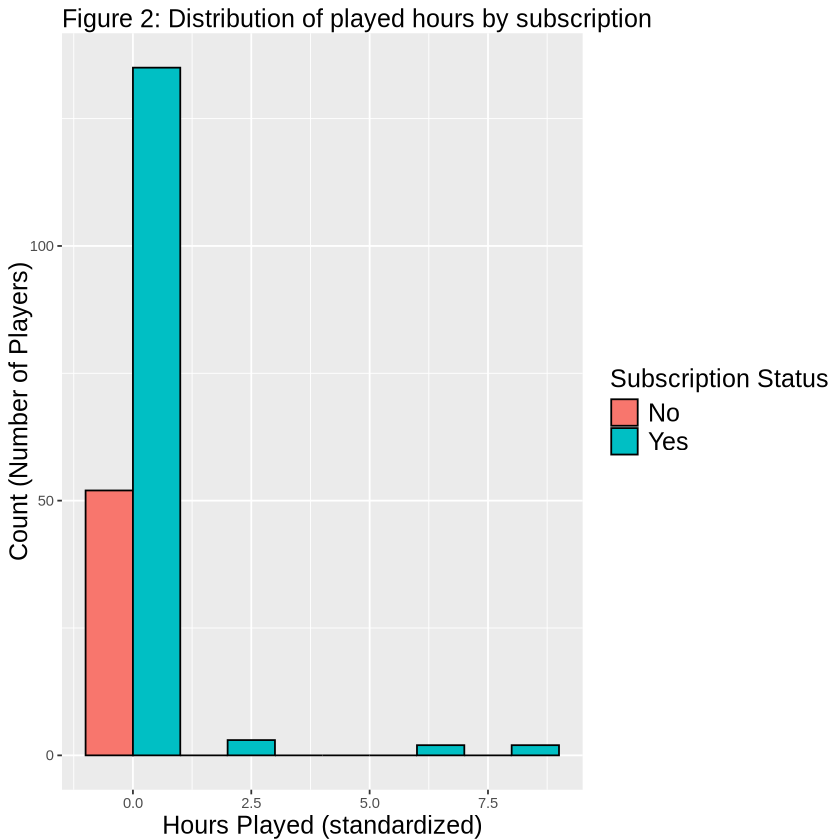

In [7]:
#Distribution of played hours by subscription Histogram. 
#This helps visualize whether how much the individuals play the game affects their subscription status. 

hours_played_plot <- ggplot(players, aes(x = played_hours, fill = subscribe)) +
geom_histogram(binwidth = 2, color = "black", position = "dodge") +
labs(x = "Hours Played (standardized)", 
     y = "Count (Number of Players)", 
     title = "Figure 2: Distribution of played hours by subscription", 
    fill = "Subscription Status") +
theme(plot.title = element_text(size = 15),
      axis.title = element_text(size = 15),
      legend.title = element_text(size = 15),
      legend.text = element_text(size = 15))

#view the plot
hours_played_plot

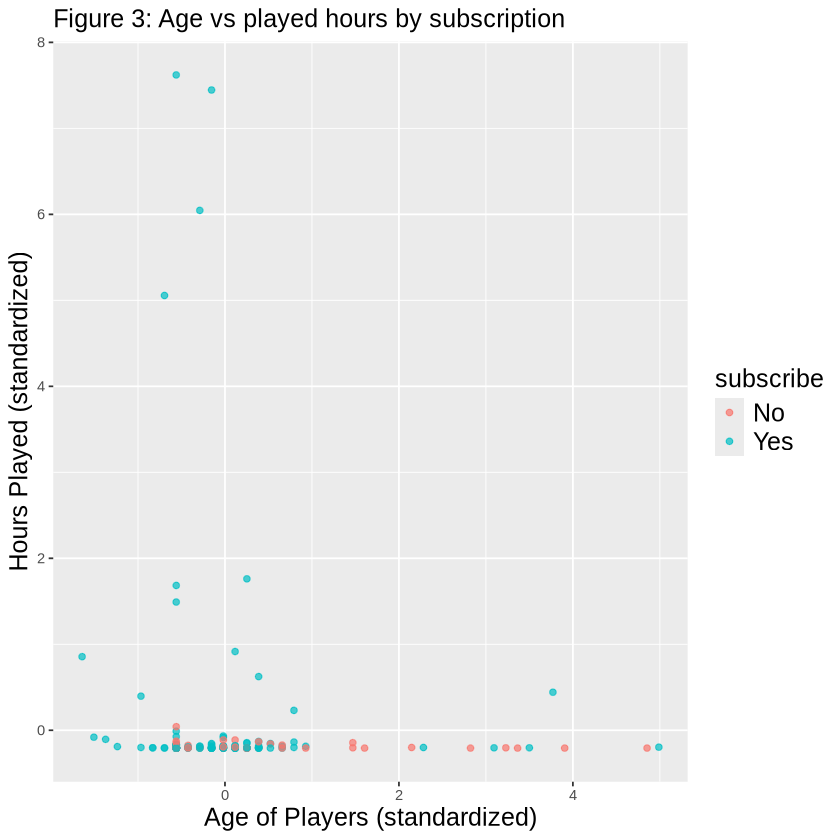

In [8]:
#Age vs Hours Played colored by subscription Scatterplot. 
#This helps visualize and depict how age and hours played relate to subscription together. 

age_vs_hours_played_plot <- ggplot(players, aes(x = Age, y = played_hours, color = subscribe)) +
geom_point(alpha = 0.7) +
labs(x = "Age of Players (standardized)", 
     y = "Hours Played (standardized)", 
     title = "Figure 3: Age vs played hours by subscription", 
    fill = "Subscription Status") +
theme(plot.title = element_text(size = 15),
      axis.title = element_text(size = 15),
      legend.title = element_text(size = 15),
      legend.text = element_text(size = 15))

#view the plot
age_vs_hours_played_plot

In [9]:
set.seed(333) #makes the result the same each time

#creating the split
players_split <- initial_split(players, prop = 0.75, strata = subscribe)  
players_train<- training(players_split)   
players_test<- testing(players_split)

head(players_train)
head(players_test)

#creating the recipe
players_recipe <- recipe(subscribe ~ Age + played_hours , data = players_train) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

#creating model and fit
knn_tune<- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

#do cross validation
players_vfold <- vfold_cv(players_train, v = 10, strata = subscribe)

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))
knn_results <- workflow() |>
      add_recipe(players_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = players_vfold, grid = k_vals) |>
      collect_metrics()
head(knn_results)

played_hours,Age,subscribe
"<dbl[,1]>","<dbl[,1]>",<fct>
-0.2071953,-0.01883372,No
-0.2071953,0.11649002,No
-0.2036863,-0.56012864,No
-0.2071953,0.25181375,No
-0.2036863,-0.42480491,No
-0.2071953,0.38713748,No


played_hours,Age,subscribe
"<dbl[,1]>","<dbl[,1]>",<fct>
-0.07385234,-0.5601286,Yes
-0.20719534,-0.5601286,No
-0.20719534,-0.5601286,Yes
-0.15455995,0.5224612,Yes
-0.20719534,-0.5601286,Yes
-0.18965021,-0.5601286,Yes


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5033700,10,0.03909801,Preprocessor1_Model01
1,roc_auc,binary,0.5162879,10,0.03848443,Preprocessor1_Model01
2,accuracy,binary,0.4895604,10,0.04108375,Preprocessor1_Model02
2,roc_auc,binary,0.5094697,10,0.05146118,Preprocessor1_Model02
3,accuracy,binary,0.5034432,10,0.04343787,Preprocessor1_Model03
3,roc_auc,binary,0.4856061,10,0.04606088,Preprocessor1_Model03


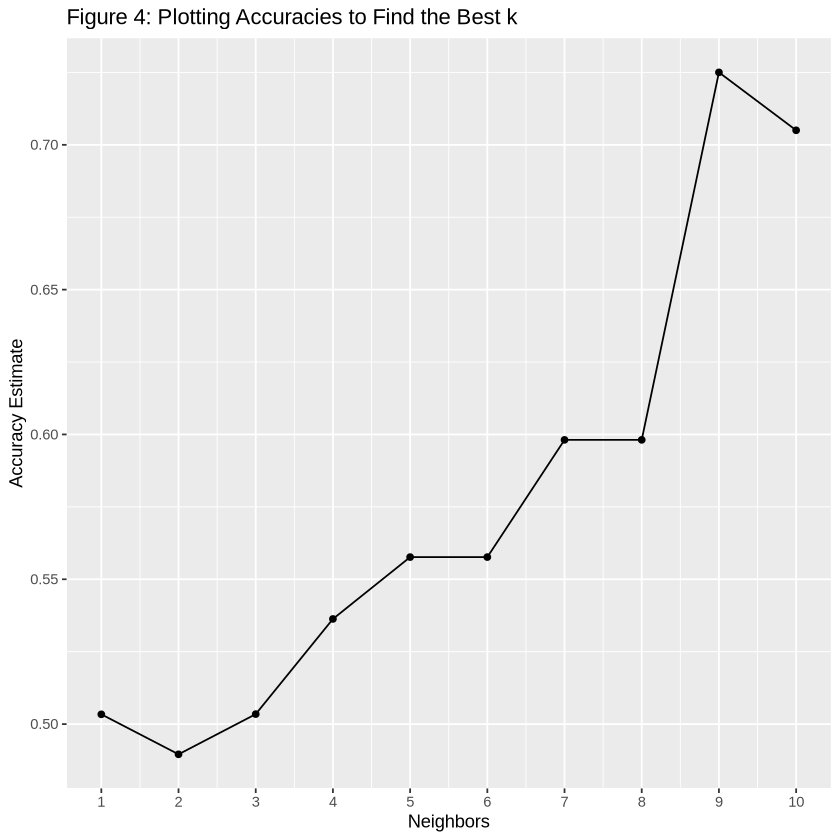

In [10]:
#get accuracies
accuracies <- knn_results |> 
      filter(.metric== "accuracy")

#plot accuracies vs k to find best k
accuracy_versus_k<- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate", title="Figure 4: Plotting Accuracies to Find the Best k") +
      scale_x_continuous(breaks = seq(0, 14, by = 1))  # adjusting the x-axis
accuracy_versus_k

In [11]:
# Building the final model

# Set the seed
set.seed(999) 

# your code here
knn_spec <- nearest_neighbor(weight_func="rectangular", neighbors = 9) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
      add_recipe(players_recipe) |>
      add_model(knn_spec) |>
      fit(data = players_train)
knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(9,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2551724
Best kernel: rectangular
Best k: 9

In [12]:
# Set the seed
set.seed(999)

# Predicting the test data set
players_predictions <- predict(knn_fit, players_test) |>
                        bind_cols(players_test)

# Reporting the accuracy of prediction
players_metrics <- players_predictions |> metrics(truth = subscribe, estimate = .pred_class)
players_metrics

# Reporting the confusion matrix
players_conf_mat <- players_predictions |>
                        conf_mat(truth = subscribe, estimate = .pred_class) 
players_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7755102
kap,binary,0.3434836


          Truth
Prediction No Yes
       No   5   3
       Yes  8  33

## Discussion

### Confusion Matrix Summary

By looking at the confusion matrix, produced through data analysis, we can conclude:

- 33 True positives
- 5 True negatives
- 8 False positives
- 3 False negatives

This tells us that the model is better at predicting positives than it is negatives. The model correctly predicted 33 of 36 subscribers but only 5 of 13 non-subscribers. This is likely because of the fact that there are many more subscribers than non-subscribers in the complete data set, causing the model to be stronger when predicting the majority class. We can conclude that subscription is predictable, but mostly when the subscription status is 'Yes', meaning age and play time help to predict if someone will subscribe but not if they wont subscribe.

It was expected that if two players were of similar age and played the game for a similar amount of time, then they would have the same subscription status. When looking at Figure 3 (Age vs. Play Time), you can see that subscription appears to be random, not particularly based on age, nor play time. It was also predicted that the model would be strong at predicting 'yes', as most players subscribed 'yes', therefore making it more likely to be correct when predicting this.

The impact of these findings is that age and play time cannot be considered strong or reliable indicators of newsletter subscription behaviour. Since the model performs well for predicting "Yes" but is very inaccurate at predicting "No", it proves that the two predictors do not capture the full pattern of why players subscribe. Our findings highlight that relying alone on these two predictors would lead to an incomplete or misleading understanding of what distinguishes subscribers and non-subscribers. The interpretation of this dataset must involve other predictors because subscription behaviour is more complex than just being caused by player age and time played.

A major limitation of this analysis is the class imbalance, which makes the model more adapted to patterns for subscribers than non-subscribers. Even after stratified splitting of the dataset, the imbalance caused the model to predict "Yes" when it was a "No". Another limitation is that subscription is likely affected by other factors not considered in this analysis and hence restricts models performance.

One major question raised by this analysis is whether more detailed and engagement related variables would allow the model to better adapt to patterns that can more accurately distinguish subscribers from non-subscribers. Perhaps variables like "experience" or others that show in-game activity like the sessions history in the sessions.csv file as well as purchase history may reveal more stronger and consistent patterns that allow the model to adapt and distinguish subscribers from non-subscribers. The second possible question is whether different modeling methods like logistic regression would be better at detecting such relationships. KNN has some limitations, such as it is reliant entirely on the similarity in the predictors. If players have almost the same age and play times but different subscription statuses, it will not be able to differentiate the two players. Expanding to utilize other models that can use non-linear trends or learn weighted relationships (learning that one predictor is important than another) would provide a far more accurate and balanced image of what exactly affects subscription status.